# Imports

In [1]:
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from scipy import stats

from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

# Read Data

In [26]:
expinput = pd.read_csv("exp_example.csv",sep=",",index_col=0)
expinput.index = expinput.index.astype(int)
                                   
comp_file = "comp_example"
comp_sheet = "Sheet1"                                
compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,index_col = 0, header = 1)
#compinp = ci[ci.columns[:-4]].loc[ci.index[:-5]]
compinp.index = compinp.index.astype(int)
compinp.dropna(axis=0,inplace=True)

print("available datasets:")
for i in expinput.columns[3:]:
    print(i)

available datasets:
yield_chloro_2to1_2hr
yield_doyle_Ni_suzuki_0020


# Select Data

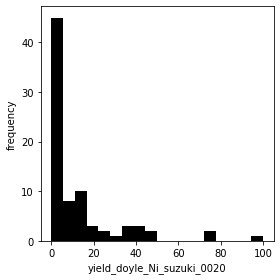

In [39]:
# select dataset and visualize data spread
dataset = "yield_doyle_Ni_suzuki_0020" #"yield_chloro_2to1_2hr"

plt.figure(figsize=(4, 4))
plt.hist(expinput[dataset].dropna(axis=0), bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(dataset)

plt.tight_layout()
plt.show()  

# Threshold Analysis

Dataset: yield_doyle_Ni_suzuki_0020
Feature: vmin_vmin_boltz
Decision threshold = -0.05
Accuracy: 0.44
f1_score: 0.55
N = 80


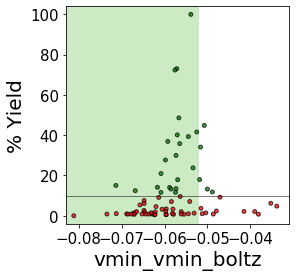

-------------------------------------------------------
Dataset: yield_doyle_Ni_suzuki_0020
Feature: vbur_vtot_boltz
Decision threshold = 258.15
Accuracy: 0.44
f1_score: 0.55
N = 80


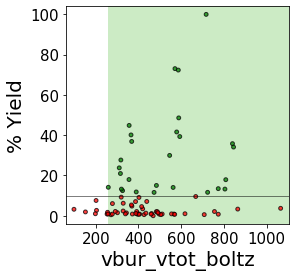

-------------------------------------------------------
Dataset: yield_doyle_Ni_suzuki_0020
Feature: Pint_P_int_boltz
Decision threshold = 17.15
Accuracy: 0.40
f1_score: 0.53
N = 80


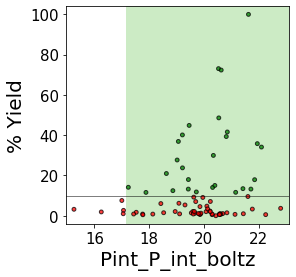

-------------------------------------------------------
Dataset: yield_doyle_Ni_suzuki_0020
Feature: vbur_vbur_boltz
Decision threshold = 63.25
Accuracy: 0.80
f1_score: 0.77
N = 80


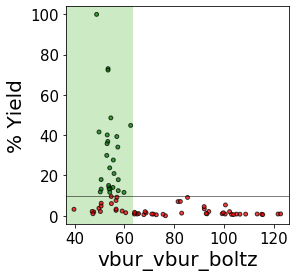

-------------------------------------------------------
Dataset: yield_doyle_Ni_suzuki_0020
Feature: percent_vbur_min
Decision threshold = 30.54
Accuracy: 0.80
f1_score: 0.77
N = 80


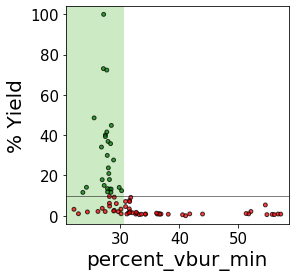

-------------------------------------------------------
Dataset: yield_doyle_Ni_suzuki_0020
Feature: vbur_vbur_min
Decision threshold = 54.85
Accuracy: 0.80
f1_score: 0.77
N = 80


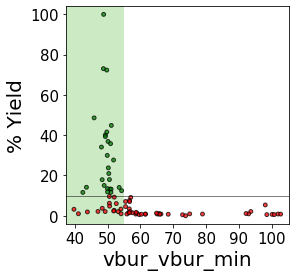

-------------------------------------------------------
Dataset: yield_doyle_Ni_suzuki_0020
Feature: vbur_vbur_max
Decision threshold = 96.34
Accuracy: 0.59
f1_score: 0.61
N = 80


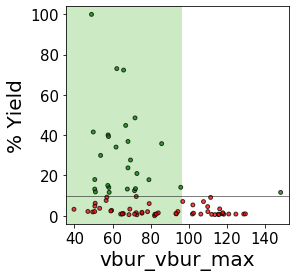

-------------------------------------------------------
Dataset: yield_doyle_Ni_suzuki_0020
Feature: vbur_vbur_delta
Decision threshold = 35.29
Accuracy: 0.34
f1_score: 0.50
N = 80


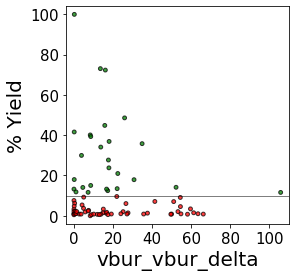

-------------------------------------------------------
Dataset: yield_doyle_Ni_suzuki_0020
Feature: vbur_vbur_vburminconf
Decision threshold = 54.85
Accuracy: 0.80
f1_score: 0.77
N = 80


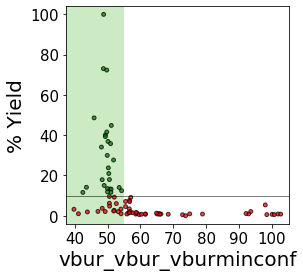

-------------------------------------------------------
Dataset: yield_doyle_Ni_suzuki_0020
Feature: sterimol_B1_boltz
Decision threshold = 3.99
Accuracy: 0.34
f1_score: 0.50
N = 80


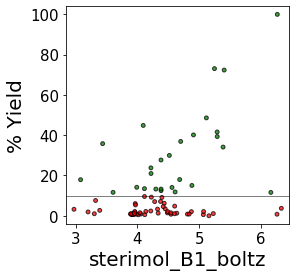

-------------------------------------------------------


In [43]:
#threshold settings
y_cut = 10   # experimental output (e.g., yield) to define inactive/active
class_weight = {0:1,1:20}   # define class weights, {0:1,1:20} penalizes false positives

#parameter settings
num_par = 10   # number of parameters
par_start_col = 2  # parameter start column (0-indexed)

X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]

#set which parameters/features to iterate through
features = range(0,10)
#features = itertools.chain(range(0,2),range(6,9))

#threshold analysis for selected features
for f_ind in features:
    feature = X_labels[f_ind] 
    
    # read in data
    y_all = expinput[dataset].dropna(axis=0)  
    X_all = np.array(compinp[feature].loc[y_all.index])
    
    # filter Buchwald ligands
    buchwaldmask = expinput["buchwald"][expinput[dataset].notna()]
    X_nobw = X_all[buchwaldmask==0]
    y_nobw = y_all[buchwaldmask==0]
    X_bw = X_all[buchwaldmask==1]
    y_bw = y_all[buchwaldmask==1]

    # select which subset of data to use for the threshold analysis (X_all, X_bw, X_nobw).  change as appropriate
    X_use =  X_all #X_nobw
    y_use =  y_all #y_nobw
    
    y_class = np.array([0 if i < y_cut else 1 for i in y_use])
    dt = DecisionTreeClassifier(max_depth=1,class_weight=class_weight).fit(X_use.reshape(-1, 1), y_class)   
    print("Dataset: {}\nFeature: {}\nDecision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(dataset,feature,
    dt.tree_.threshold[0],
    dt.score(X_use.reshape(-1, 1), y_class),
    metrics.f1_score(y_class,dt.predict(X_use.reshape(-1, 1))),
    len(y_use)
    ))
    
    # begin plot
    dt_plt = DecisionTreeClassifier(max_depth=1,class_weight=class_weight).fit(X_use.reshape(-1, 1), y_class)
    n_classes = 2
    plot_step = 0.02
    
    # define plot axes limits here as appropriate 
    #x_min, x_max = 20, 80
    #y_min, y_max = 0, 100
    x_min, x_max = X_all.min(), X_all.max()
    y_min, y_max = y_all.min(), y_all.max()
    
    # set plot colors
    cMap_background = ListedColormap(['white', '#ccebc5',]) # color for the backgrounds: light green and red
    cMap_points = ListedColormap(["r","g"]) # the color for each class of the actual data points (i.e. inactive/active)). "rg" is red,green
    bwcolor = "#999999" # color for points removed from threshold analysis, e.g. Buchwald ligands
    
    # plot code
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    plt.figure(figsize=(4, 4))    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cMap_background)
    
    # Axis labels
    plt.xlabel(feature,fontsize=20)
    plt.ylabel("% Yield", fontsize=20)  #change as appropriate. e.g., yield, selectivity, $ΔΔG^{≠}$
    
    plt.scatter(X_use,y_use,c=y_class,cmap=cMap_points,edgecolor="black",s=15, alpha=0.75)
    
    # Plot points that were removed from threshold analysis (e.g., buchwald ligands). Comment out if not needed.
    #plt.scatter(X_bw,y_bw,c=bwcolor,edgecolor=bwcolor,s=15, alpha=0.75)
    
    plt.xticks(fontsize=15) 
    plt.yticks(fontsize=15)
    
    # Plot horizontal line to indicate y_cut 
    plt.axhline(y = y_cut, color = 'black', linestyle = '-', linewidth = 0.5)
    
    # Print plot
    plt.show()
    
    #optional save plot as .png
    figname = "threshold_{}_{}".format(dataset,feature)
    #plt.savefig(figname,dpi=300,bbox_inches = 'tight')
    
    print('-------------------------------------------------------')